In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from pycaret.regression import *
from sklearn.model_selection import train_test_split

import shap

In [2]:
df = pd.read_excel('Data\mediamarkt_products.xlsx')

In [3]:
selected_cols = [
    "price", "Termék típusa",
    "Operációs rendszer", "Kapacitás", "Memóriaméret",
    "Képernyőátló", "Felbontás szélesség", "Felbontás magasság",
    "Hátsó kamera", "Hátsó kamera felbontás", "Előlapi kamera",
    "Előlapi kamera felbontása", "Arcfelismerés", "Dual SIM",
    "Szélesség", "Magasság", "Mélység",
    "Tömeg", "Akkumulátor kapacitás", #"Modell azonosító", "reviews"
]

In [4]:
df = df[selected_cols]
df = df.rename(
    columns={
    "Termék típusa":"type",
    "Operációs rendszer":"op",
    "Kapacitás":"capacity",
    "Memóriaméret":"memory",
    "Képernyőátló":"screen_diagonal",
    "Felbontás szélesség":"pixel_w",
    "Felbontás magasság":"pixel_h",
    "Hátsó kamera":"back_camera",
    "Hátsó kamera felbontás":"back_camera_resolution",
    "Előlapi kamera":"front_camera",
    "Előlapi kamera felbontása":"front_camera_resolution",
    "Arcfelismerés":"face_id",
    "Dual SIM":"dual_sim",
    "Szélesség":"w",
    "Magasság":"h",
    "Mélység":"d",
    "Tömeg":"mass",
    "Akkumulátor kapacitás":"battery",
    #"Modell azonosító":"model_id",
    }
)

In [5]:
for col in df.columns:
    unique_vals = df[col].unique().tolist() 
    num_missing = df[col].isnull().sum()
    
    print(f"Column: {col}")
    print(f"  Unique Values: {unique_vals}")
    print(f"  Number of Missing: {num_missing}")
    print("-" * 40)

Column: price
  Unique Values: ['233\xa0999,', '33\xa0999,', '239\xa0999,', '299\xa0999,', '339\xa0999,', '154\xa0999,', '7\xa0299,', '124\xa0999,', '74\xa0999,', '37\xa0999,', '489\xa0999,', '310\xa0999,', '51\xa0700,', '59\xa0900,', '59\xa0999,', '219\xa0999,', '55\xa0999,', '64\xa0999,', '34\xa0900,', '138\xa0999,', '129\xa0999,', '68\xa0999,', '273\xa0999,', '60\xa0999,', '60\xa0900,', '109\xa0999,', '89\xa0999,', '49\xa0900,', '22\xa0999,', '434\xa0999,', '379\xa0999,', '13\xa0799,', '289\xa0999,', '242\xa0999,', '449\xa0999,', '94\xa0999,', '649\xa0999,', '54\xa0999,', '389\xa0999,', '119\xa0999,', '39\xa0999,', '27\xa0900,', '399\xa0900,', '49\xa0999,', '18\xa0699,', '42\xa0900,', '69\xa0999,', '10\xa0999,', '99\xa0999,', '67\xa0999,', '394\xa0900,', '134\xa0999,', '144\xa0999,', '59\xa0499,', '549\xa0999,', '499\xa0999,', '30\xa0999,', '23\xa0199,', '79\xa0900,', '12\xa0999,', '22\xa0799,', '269\xa0990,', '169\xa0999,', '199\xa0999,', '429\xa0999,', '274\xa0999,', '55\xa0900,',

In [6]:
df['price'] = df['price'].str.strip(',')
df['price'] = df['price'].str.replace(r'[\s\u00A0,]', '', regex=True)
df['price'] = df['price'].astype(int)

In [7]:
# Reviews
#df['reviews'] = df['reviews'].str.split(' ').str[0].astype(int)
#df.reviews.isna().sum() # none missing

In [8]:
# Type
df = df.dropna(subset=['type']).reset_index(drop=True) # 4 missing (all columns)

df['type'] = df['type'].str.lower()
df = df[df['type'].str.contains('okostelefon', case=False, na=False)].copy()

df.loc[:, 'type'] = df['type'].apply(lambda x: 'iphone' if 'iphone' in x.lower() else 'okostelefon')
df.type = df.type.map({'iphone': 1, 'okostelefon': 0})

In [9]:
# Op rendszer
df = df.drop(['op'], axis=1) # equal to type

In [10]:
# Capacity
df = df.replace({'capacity': {'1 TB': '1024 GB'}})
df['capacity'] = df['capacity'].str.split(' ').str[0].astype(int)

In [11]:
# Memory
df['memory'] = df['memory'].str.split(' ').str[0].astype(int)

In [12]:
# Screen diagonal
df['screen_diagonal'] = df['screen_diagonal'].str.split(' ').str[0].astype(float)

In [13]:
# Pixel width & height
df = df.dropna(subset=['pixel_w', 'pixel_h'])
df['pixel_w'] = df['pixel_w'].str.split(' ').str[0].astype(int)
df['pixel_h'] = df['pixel_h'].str.split(' ').str[0].astype(int)

In [14]:
# Back camera & resolution
df.back_camera = df.back_camera.map({'Single Cam': 1, 'Dual Cam': 2, 'Triple Cam': 3, 'Quad Cam': 4})

#df.back_camera.hist()

df['back_camera_resolution'] = df['back_camera_resolution'].str.extract(r'(\d+)').astype(float)
df['back_camera_resolution'] = df['back_camera_resolution'].fillna(df['back_camera_resolution'].median())

In [15]:
# Front camera & resolution
df.front_camera = df.front_camera.map({'Single Cam': 1, 'Dual Cam': 2})
df['front_camera_resolution'] = df['front_camera_resolution'].str.split(' ').str[0].astype(int)


In [16]:
# Face ID & Dual Sim
df['face_id'] = df['face_id'].replace({'Igen': 1, 'Nem': 0}).fillna(0).astype(int)
df['dual_sim'] = df['dual_sim'].replace({'Igen': 1, 'Nem': 0}).fillna(0).astype(int)

In [17]:
# Width & Height & Depth
df.w = df.w.str.split(' ').str[0].astype(float)
df.h = df.h.str.split(' ').str[0].astype(float)
df.d = df.d.str.split(' ').str[0].astype(float)

#plt.hist(df.h)
#plt.hist(df.w)

df = df[df.h > 100]
df = df[df.w < 100]

In [18]:
# Mass
df.mass = df.mass.str.split(' ').str[0].astype(float)
df.loc[df['mass'] < 1, 'mass'] = df.loc[df['mass'] < 1, 'mass'] * 1000

In [19]:
# Battery
df['battery'] = df['battery'].str.extract(r'(\d+)').astype(float)
df['battery'] = df['battery'].fillna(df['battery'].median())

In [20]:
df.isna().sum()

price                      0
type                       0
capacity                   0
memory                     0
screen_diagonal            0
pixel_w                    0
pixel_h                    0
back_camera                0
back_camera_resolution     0
front_camera               0
front_camera_resolution    0
face_id                    0
dual_sim                   0
w                          0
h                          0
d                          0
mass                       0
battery                    0
dtype: int64

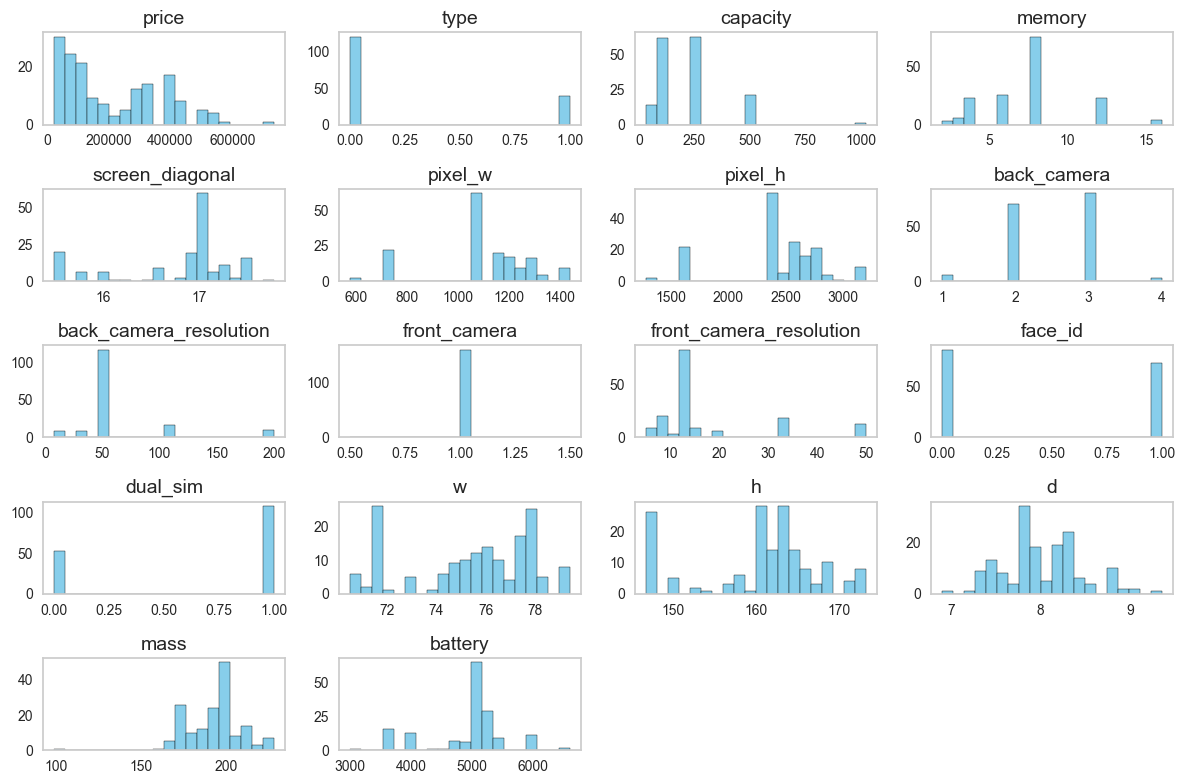

In [21]:
ax = df.hist(
    figsize=(12, 8),       # bigger figure size
    bins=20,               # number of bins
    edgecolor='black',     # black edges for bars
    color='skyblue',       # bar color
    grid=False             # optional: remove grid lines
)

# Beautify each subplot
for a in ax.ravel():
    a.set_title(a.get_title(), fontsize=14)
    a.set_xlabel(a.get_xlabel(), fontsize=12)
    a.set_ylabel(a.get_ylabel(), fontsize=12)
    a.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

In [22]:
df = df.drop(['front_camera'], axis=1)

In [23]:
df

,price,type,capacity,memory,screen_diagonal,pixel_w,pixel_h,back_camera,back_camera_resolution,front_camera_resolution,face_id,dual_sim,w,h,d,mass,battery
0,233999,0,512,12,16.94,1220,2712,3,50.0,50,0,0,73.06,160.69,8.24,186.0,6000.0
1,33999,0,64,3,17.47,720,1640,2,32.0,8,1,1,79.40,173.30,8.26,198.0,5200.0
2,239999,1,128,6,15.49,1170,2532,2,12.0,12,1,0,71.50,146.70,7.80,172.0,5000.0
3,299999,0,512,12,17.01,1280,2800,3,200.0,50,0,1,76.00,160.80,8.30,202.0,5300.0
4,339999,1,128,6,17.00,1290,2796,2,48.0,12,1,0,77.80,160.90,7.80,201.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,449999,1,128,8,16.00,1206,2622,3,48.0,12,1,0,71.50,149.60,8.25,199.0,3577.0
170,169999,0,256,8,16.63,1264,2736,2,200.0,50,0,1,74.50,156.30,7.50,182.0,5300.0
171,60999,0,128,4,17.00,1080,2400,3,50.0,13,0,1,77.80,168.00,8.80,195.0,5000.0
173,199999,0,512,12,16.94,1220,2712,3,50.0,32,1,1,75.10,160.50,7.80,195.0,5000.0


In [24]:
# Specify column types
binary_cat = ['type', 'face_id', 'dual_sim']
ordinal_cat = ['back_camera']
numeric_columns = [
 'capacity', 'memory', 'screen_diagonal', 
 'pixel_w', 'pixel_h', 'back_camera_resolution',
 'front_camera_resolution', 'w', 'h', 
 'd', 'mass', 'battery'
 ]


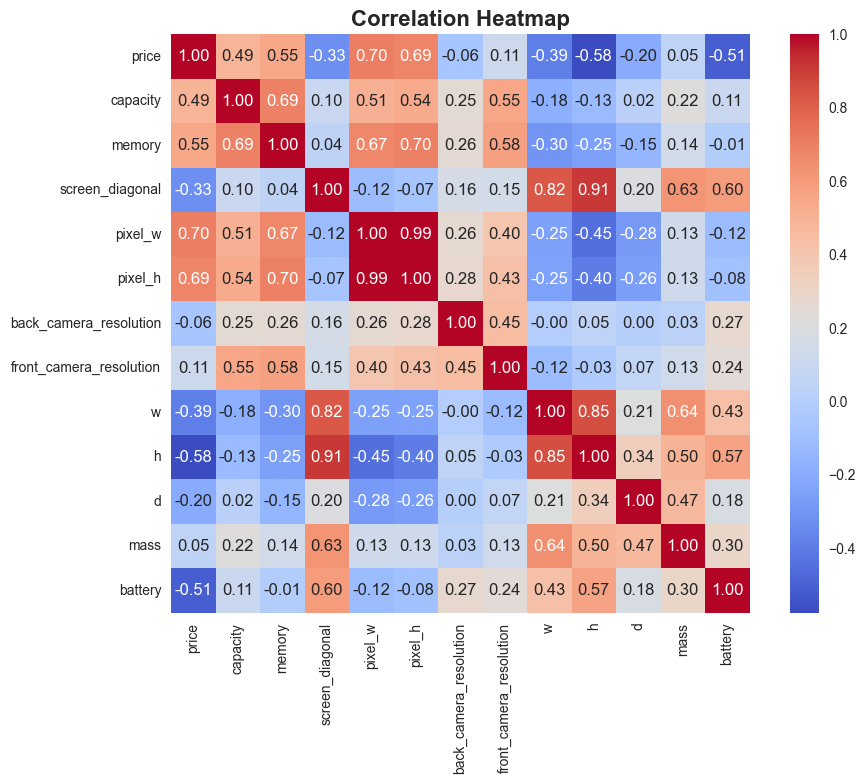

In [25]:
corr = df[['price'] + numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,       # Show correlation numbers
    fmt=".2f",        # 2 decimal places
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
# Multicollinearity
# - Unstable coefficients
# - Inflated standard errors
# - Interpretation issues
# - Feature importance can be misleading

df['aspect_ratio'] = df['h'] / df['w']
df['pixel_count'] = df['pixel_w'] * df['pixel_h']
df['volume'] = df['w'] * df['h'] * df['d']

df = df.drop(columns=['pixel_w', 'pixel_h', 'w', 'h', 'd'])

In [28]:
numeric_columns = [
 'capacity', 'memory', 'screen_diagonal', 
 'aspect_ratio', 'pixel_count', 'back_camera_resolution',
 'front_camera_resolution', 'volume', 'mass', 'battery'
 ]

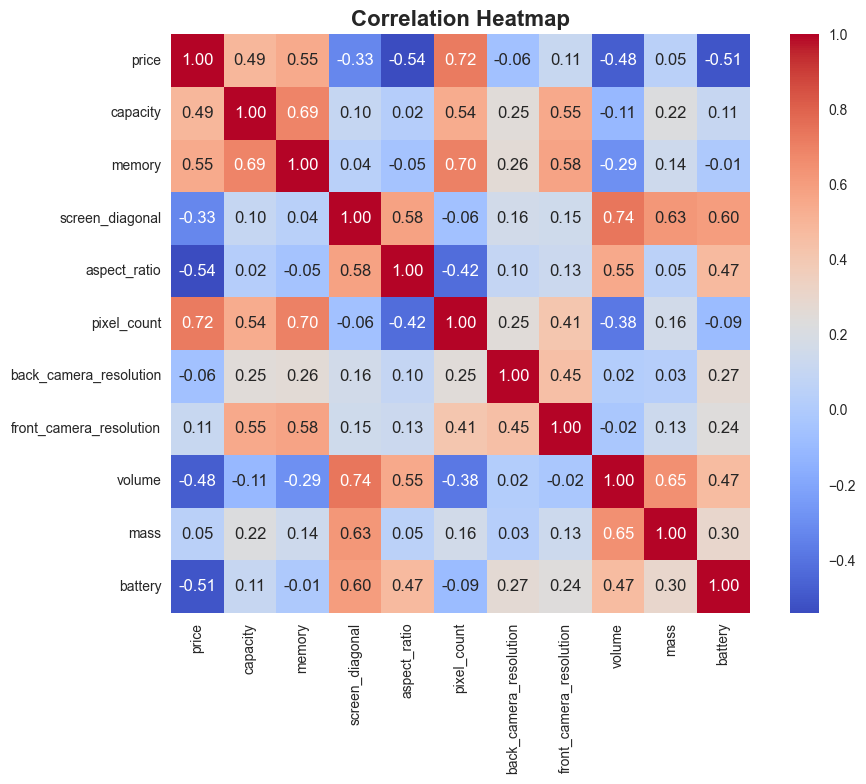

In [29]:
corr = df[['price'] + numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,       # Show correlation numbers
    fmt=".2f",        # 2 decimal places
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [30]:
stats = {}
for col in numeric_columns:
    if col in df.columns:
        stats[col] = {
            'min': float(df[col].min()),
            'max': float(df[col].max()),
            'mean': float(df[col].mean()),
            'std': float(df[col].std()),
        }

# Save to YAML
with open('numeric_stats.yaml', 'w') as f:
    yaml.dump(stats, f, sort_keys=False)

In [31]:
# Apply min-max normalization
df[numeric_columns] = df[numeric_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [32]:
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [33]:
regression_setup = setup(
    data=train_val_df,
    target='price',
    train_size=0.8,
    numeric_features=numeric_columns,
    categorical_features=binary_cat + ordinal_cat,
    ordinal_features={
        'back_camera': ['1', '2', '3', '4']    # adjust levels accordingly
    },
    normalize=False,  # already normalized
    session_id=42,
    verbose=False
)

In [34]:
best_model = compare_models(n_select=1, sort='MAE')
tuned_model = tune_model(best_model)

final_model = finalize_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,13799.5655,1099138213.4586,30077.5647,0.9450,0.1595,0.0882,0.0240
gbr,Gradient Boosting Regressor,15123.2614,1017620535.4761,28737.4928,0.9497,0.1869,0.1210,0.0170
dt,Decision Tree Regressor,16444.2992,1648120113.6087,35748.0001,0.9224,0.1945,0.1157,0.0120
rf,Random Forest Regressor,22668.8721,1591580884.5221,37538.4638,0.9249,0.1914,0.1402,0.0250
lightgbm,Light Gradient Boosting Machine,28581.7124,1973031413.1428,43218.6164,0.9007,0.2581,0.2097,0.0270
ada,AdaBoost Regressor,33569.5184,2274074072.8015,45503.5324,0.8856,0.3148,0.2909,0.0190
knn,K Neighbors Regressor,41482.5709,4411593089.7119,62656.1778,0.7621,0.3058,0.2242,0.0140
ridge,Ridge Regression,49879.6004,3902801186.3644,61016.3571,0.8075,0.6361,0.4205,0.0110
llar,Lasso Least Angle Regression,49978.6774,3928956999.9189,61897.0838,0.7933,0.6186,0.4991,0.0130
lasso,Lasso Regression,49978.8703,3928979650.6808,61897.2454,0.7933,0.6187,0.4991,0.2340


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,29186.2000,1705430521.3938,41296.8585,0.9090,0.3462,0.2819
1,27422.9552,1825054209.8131,42720.6532,0.9140,0.1757,0.1404
2,32261.4917,2619058706.4653,51176.7399,0.9226,0.2171,0.1791
3,38372.3693,2960050353.6675,54406.3448,0.8934,0.2519,0.2013
4,32272.8027,2441686975.9038,49413.4291,0.8897,0.2599,0.1865
5,32040.6453,2437783981.0698,49373.9200,0.8304,0.2239,0.2070
6,29427.6589,2039159171.5276,45157.0501,0.8336,0.2120,0.1761
7,42579.3869,4357252662.7953,66009.4892,0.8790,0.2015,0.1389
8,7852.9618,84752024.8434,9206.0863,0.9952,0.0977,0.0706


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
save_model(final_model, 'Models/best_regression_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['capacity', 'memory',
                                              'screen_diagonal', 'aspect_ratio',
                                              'pixel_count',
                                              'back_camera_resolution',
                                              'front_camera_resolution',
                                              'volume', 'mass', 'battery'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['type', 'face_id', 'dual_sim',
                                              'b...
                                                                          'data_type': dtype('float64'),
                                                                          'mapping': 0.0    0
 1.0    1
 NaN   -1
 dtype: int64},
                 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,25416.8035,2745356953.1199,52396.1540,0.8966,0.2216,0.1696


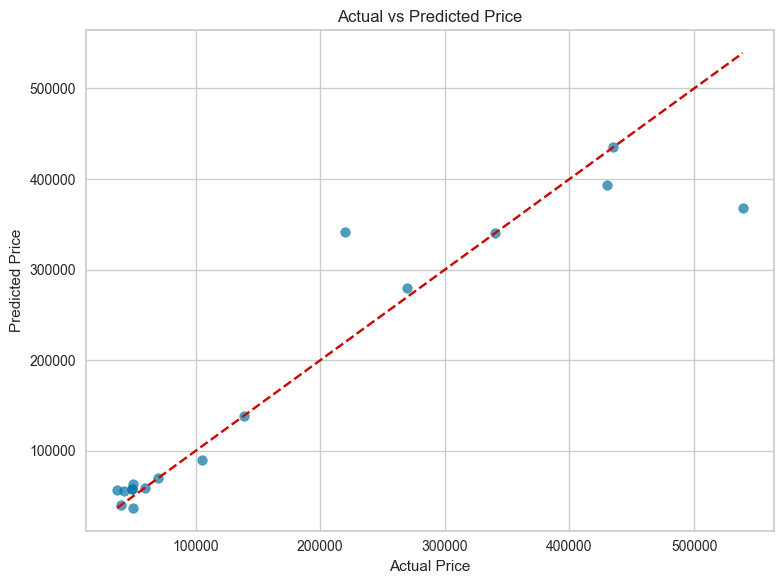

In [36]:
predictions = predict_model(final_model, data=test_df)

plt.figure(figsize=(8, 6))
plt.scatter(predictions['price'], predictions['prediction_label'], alpha=0.7)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.plot([predictions['price'].min(), predictions['price'].max()],
         [predictions['price'].min(), predictions['price'].max()],
         'r--')  # diagonal line
plt.grid(True)
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 162it [02:07,  1.26it/s]                         


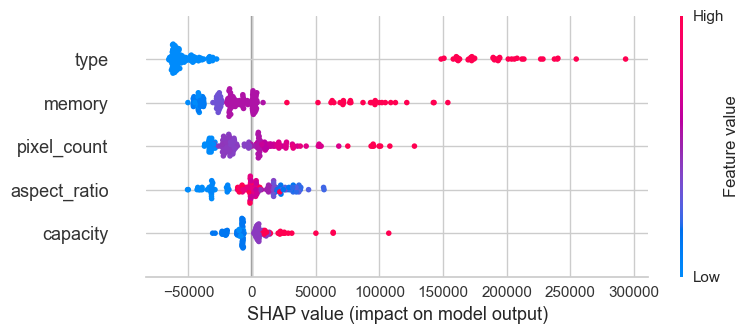

In [37]:
X = df.drop(columns=['price'])

explainer = shap.Explainer(final_model.predict, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, max_display=5)